In [62]:
! ls data

ELUT_bond.fasta                    ElloLutescens_male_dna.gtf
ELUT_bond.gff                      ElloLutescens_matches.bed
ELUT_bond_doubled.fasta            ElloLutescens_matches.fasta
ELUT_female.fasta                  ElloLutescens_matches_offset.bed
ETAL_bond.fasta                    ElloLutescens_matches_offset.fasta
ETAL_female.fasta                  ElloLutescens_mtdna.intersect
ElloLutescens.blastn               ElloLutescens_mtdna_matches.bed
ElloLutescens.csv                  arvicolinae.fasta
ElloLutescens_RepeatMasker.gff     cricetidae.fasta
ElloLutescens_dna.intersect        representative_sequences.fasta
ElloLutescens_male_dna.fasta       rodentia.fasta
ElloLutescens_male_dna.fasta.fai


# Helper functions and classes

In [10]:
from dataclasses import dataclass
from typing import TextIO, Iterable, List, Optional


@dataclass
class FASTASequence:
    title: str
    sequence: str


def parse_fasta(io: TextIO) -> Iterable[FASTASequence]:
    curr_title: Optional[str] = None
    curr_sequence_parts: List[str] = []

    def flush() -> Iterable[FASTASequence]:
        if curr_title:
            yield FASTASequence(title=curr_title, sequence="".join(curr_sequence_parts).upper())

    for line in io:
        if line.startswith(">"):
            yield from flush()
            curr_title = line[1:].strip()
            curr_sequence_parts = []
        else:
            curr_sequence_parts.append(line.strip())

    yield from flush()


def write_fasta(io: TextIO, seqs: Iterable[FASTASequence], line_width: int = 70):
    for seq in seqs:
        print(f">{seq.title}", file=io)
        for i in range(0, len(seq.sequence), line_width):
            if i + line_width <= len(seq.sequence):
                fragment = seq.sequence[i : i + line_width]
            else:
                fragment = seq.sequence[i:]
            print(fragment, file=io)

# Scatter plot of GC content of different rodent mtDNAs

data/ELUT_female.fasta 0.43119919302201387
data/ELUT_female.fasta 0.4299115359496527
data/ELUT_female.fasta 0.43119919302201387
data/ELUT_female.fasta 0.4299115359496527
data/ELUT_female.fasta 0.43119919302201387
data/ELUT_female.fasta 0.4299115359496527


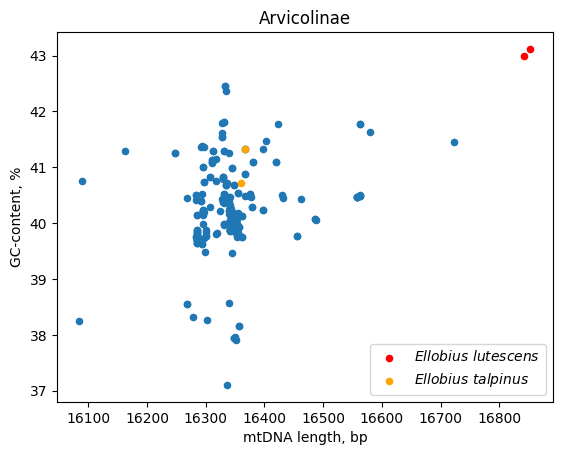

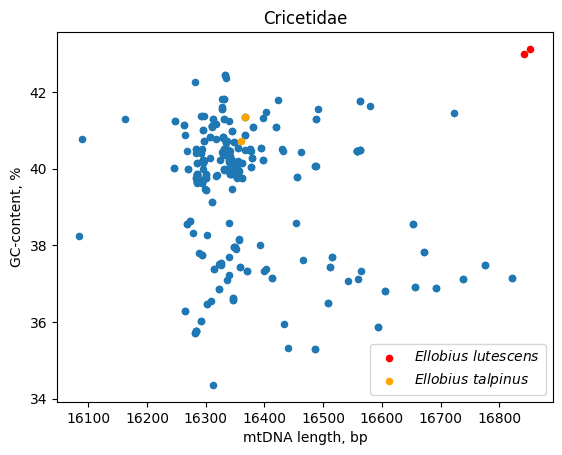

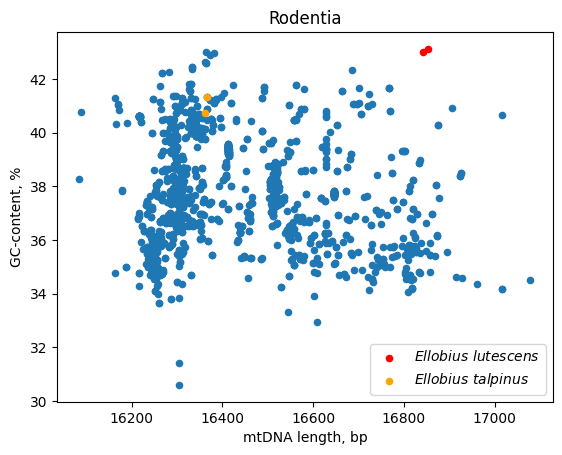

In [6]:
from matplotlib import pyplot as plt
import os

def gc_content(seq):
    return (seq.count("G") + seq.count("C")) / len(seq)

for filename, taxon in [
    ("data/arvicolinae.fasta", "Arvicolinae"), 
    ("data/cricetidae.fasta", "Cricetidae"), 
    ("data/rodentia.fasta", "Rodentia"),
]:
    plt.figure()
    plt.title(taxon)
    with open(filename) as f:
        seqs = parse_fasta(f)
        xs, ys = zip(*(
            (len(seq.sequence), 100*gc_content(seq.sequence)) 
            for seq in seqs 
            if len(seq.sequence) > 16000
            and "gene" not in seq.title 
            and "D-loop" not in seq.title
            and "control region" not in seq.title
            and "RNA-Asp" not in seq.title
            and "antisense RNA" not in seq.title
        ))
        plt.scatter(xs, ys, s=20)

    xs, ys = [], []
    for filename in ["data/ELUT_female.fasta", "data/ELUT_bond.fasta"]:
        with open(filename) as f:
            seq, = parse_fasta(f)
        xs.append(len(seq.sequence))
        ys.append(100*gc_content(seq.sequence))
        print(name, gc_content(seq.sequence))
    plt.scatter(xs, ys, s=20, color="r", label="$\it{Ellobius\ lutescens}$")
    xs, ys = [], []
    for filename in ["data/ETAL_female.fasta", "data/ETAL_bond.fasta"]:
        with open(filename) as f:
            seq, = parse_fasta(f)
        xs.append(len(seq.sequence))
        ys.append(100*gc_content(seq.sequence))
    plt.scatter(xs, ys, s=20, color="orange", label="$\it{Ellobius\ talpinus}$")
    plt.xlabel("mtDNA length, bp")
    plt.ylabel("GC-content, %")
    plt.legend();

# Finding NUMTs with BLAST and visualizing

First, doubling the mtDNA to account for matches on sequence boundaries.

In [68]:
with open("data/ELUT_bond.fasta") as f:
    seq = next(iter(parse_fasta(f)))
lutescens_mtdna_length = len(seq.sequence)
with open("data/ELUT_bond_doubled.fasta", "w") as f:
    write_fasta(f, [FASTASequence(title=seq.title, sequence=seq.sequence*2)])
    
with open("data/ETAL_bond.fasta") as f:
    seq = next(iter(parse_fasta(f)))
talpinus_mtdna_length = len(seq.sequence)
with open("data/ETAL_bond_doubled.fasta", "w") as f:
    write_fasta(f, [FASTASequence(title=seq.title, sequence=seq.sequence*2)])

In [ ]:
! blastn -query data/ELUT_bond.fasta -subject data/ElloLutescens_male_dna.fasta \
    -evalue 0.5 -outfmt "6 sseqid pident length mismatch gapopen qstart qend sstart send slen evalue" \
    > data/ElloLutescens.blastn

! blastn -query data/ETAL_bond.fasta -subject data/ElloTalpinus_dna.fasta \
    -evalue 0.5 -outfmt "6 sseqid pident length mismatch gapopen qstart qend sstart send slen evalue" \
    > data/ElloTalpinus.blastn

In [64]:
def convert_blast_results_to_dna_bed(blast_f, matches_f, matches_offset_f):
    for line in blast_f:
        sseqid, _, _, _, _, _, _, sstart, send, slen, _ = line.split()
        sstart, send, slen = int(sstart), int(send), int(slen)
        begin, end = min(sstart, send), max(sstart, send)
        direction = '+' if sstart < send else '-'
        print(sseqid, begin, end, '_', 0, direction, sep='\t', file=matches_f)
        print(sseqid, max(0, begin - 5000), min(slen, end + 5000), '_', 0, direction, sep='\t', file=matches_offset_f)

with open("data/ElloLutescens.blastn") as f, \
        open("data/ElloLutescens_matches.bed", "w") as out, \
        open("data/ElloLutescens_matches_offset.bed", "w") as out2:
    convert_blast_results_to_dna_bed(f, out, out2)

with open("data/ElloTalpinus.blastn") as f, \
        open("data/ElloTalpinus_matches.bed", "w") as out, \
        open("data/ElloTalpinus_matches_offset.bed", "w") as out2:
    convert_blast_results_to_dna_bed(f, out, out2)

In [ ]:
! bedtools getfasta -fi data/ElloLutescens_male_dna.fasta -bed data/ElloLutescens_matches.bed > data/ElloLutescens_matches.fasta
! bedtools getfasta -fi data/ElloLutescens_male_dna.fasta -bed data/ElloLutescens_matches_offset.bed > data/ElloLutescens_matches_offset.fasta
! bedtools getfasta -fi data/ElloTalpinus_dna.fasta -bed data/ElloTalpinus_matches.bed > data/ElloTalpinus_matches.fasta
! bedtools getfasta -fi data/ElloTalpinus_dna.fasta -bed data/ElloTalpinus_matches_offset.bed > data/ElloTalpinus_matches_offset.fasta

In [65]:
def extract_gff_sequence_name(gff_f):
    for line in f:
        gff_sequence_name, _ = line.split("\t", 1)
        return gff_sequence_name
    

def convert_blast_results_to_mtdna_bed(blast_f, matches_f, gff_sequence_name):
    for i, line in enumerate(blast_f):
        sseqid, pident, _, _, _, qstart, qend, sstart, send, slen, _ = line.split()
        qstart, qend = int(qstart), int(qend)
        begin, end = min(qstart, qend), max(qstart, qend)
        direction = '+' if sstart < send else '-'
        print(
            gff_sequence_name, begin, end, 
            f'alignment_{i}_identity_{pident}_scaffold_{sseqid}_{sstart}_{send}_{slen}', 0, direction, 
            sep='\t', file=matches_f,
        )


with open("data/ELUT_bond.gff") as f:
    lutescens_gff_sequence_name = extract_gff_sequence_name(f)

with open("data/ElloLutescens.blastn") as f, \
        open("data/ElloLutescens_mtdna_matches.bed", "w") as out:
    convert_blast_results_to_mtdna_bed(f, out, lutescens_gff_sequence_name)
    
with open("data/ETAL_bond.gff") as f:
    talpinus_gff_sequence_name = extract_gff_sequence_name(f)

with open("data/ElloTalpinus.blastn") as f, \
        open("data/ElloTalpinus_mtdna_matches.bed", "w") as out:
    convert_blast_results_to_mtdna_bed(f, out, talpinus_gff_sequence_name)

In [ ]:
! bedtools intersect -a data/ElloLutescens_mtdna_matches.bed -b data/ELUT_bond.gff -wa -wb > data/ElloLutescens_mtdna.intersect
! bedtools intersect -a data/ElloTalpinus_mtdna_matches.bed -b data/ETAL_bond.gff -wa -wb > data/ElloTalpinus_mtdna.intersect

In [124]:
from collections import defaultdict
import csv
from dataclasses import dataclass


@dataclass(frozen=True)
class Alignment:
    index: int

    # Position on mtDNA:
    start: int
    end: int

    direction: str
    identity: str

    # Position on DNA:
    scaffold: str
    sstart: int
    send: int
    slen: int

    def intersects(self, start, end) -> bool:
        return start <= self.start < end or start < self.end <= end or self.start < start < end < self.end


def format_feature(kind, id):
    if kind == "gene" or kind == "ncRNA_gene":
        return f"gene {id.removeprefix('gene-').removeprefix('gene_')}"
    if kind == "exon":
        return f"exon {id.removeprefix('exon-').removeprefix('exon_')}"
    if kind == "CDS":
        return f"CDS {id.removeprefix('cds-').removeprefix('cds_')}"
    if kind in ("D_loop", "origin_of_replication"):
        return kind
    return f"{kind} {id}"


def load_alignments(blast_f):
    alignments = []
    for i, line in enumerate(blast_f):
        # sseqid pident length mismatch gapopen qstart qend sstart send slen evalue
        scaffold, identity, _, _, _, start, end, sstart, send, slen, *_ = line.split("\t")
        sstart, send = int(sstart), int(send)
        alignment = Alignment(
            index=i, start=int(start), end=int(end), direction="+" if sstart < send else "-", identity=identity, 
            scaffold=scaffold, sstart=min(sstart, send), send=max(sstart, send), slen=int(slen),
        )
        alignments.append(alignment)
    return alignments


def load_alignments_and_features(intersect_f, features_f):
    features_per_alignment = defaultdict(list)

    for line in intersect_f:
        parts = line.split("\t")
        begin = int(parts[1])
        end = int(parts[2])
        direction = parts[5]
        alignment = parts[3]
        kind = parts[8]
        details = {k: v for detail in parts[14].split(";") for k, v in [detail.split("=", 1)]}

        _, alignment_index, _, identity, _, scaffold, sstart, send, slen = alignment.split("_")
        alignment = Alignment(
            index=alignment_index, start=begin, end=end, direction=direction, identity=identity, 
            scaffold=scaffold, sstart=int(sstart), send=int(send), slen=int(slen),
        )
        features_per_alignment[alignment]
                
        if kind == "CDS" or "ID" not in details:
            continue
        features_per_alignment[alignment].append(format_feature(kind, details["ID"]))

    header = ("Alignment", "Identity", "mtDNA start", "mtDNA end", "Scaffold", "Scaffold start", "Scaffold end", "Scaffold length")
    column_names = sorted({f for features in features_per_alignment.values() for f in features})
    name_to_idx = {c: i + len(header) for i, c in enumerate(column_names) }

    w = csv.writer(features_f)
    w.writerow(header + tuple(column_names))
    for alignment, features in features_per_alignment.items():
        row = [alignment.index, alignment.identity, alignment.start, alignment.end, alignment.scaffold, alignment.sstart, alignment.send, alignment.slen] + [""] * len(column_names)
        for feature in features:
            row[name_to_idx[feature]] = "■"
        w.writerow(row)

    alignments = [*features_per_alignment]
    return alignments


with open("data/ElloLutescens_mtdna.intersect") as f, open("data/ElloLutescens.csv", "w") as out:
    load_alignments_and_features(f, out)
    
with open("data/ElloTalpinus_mtdna.intersect") as f, open("data/ElloTalpinus.csv", "w") as out:
    load_alignments_and_features(f, out)
    
with open("data/ElloLutescens.blastn") as f:
    lutescens_alignments = load_alignments(f)

with open("data/ElloTalpinus.blastn") as f:
    talpinus_alignments = load_alignments(f)

len(lutescens_alignments), len(talpinus_alignments)

(167, 463)

Min identity: 71.489, max identity: 100.0
Min identity: 74.818, max identity: 100.0


<Figure size 640x480 with 0 Axes>

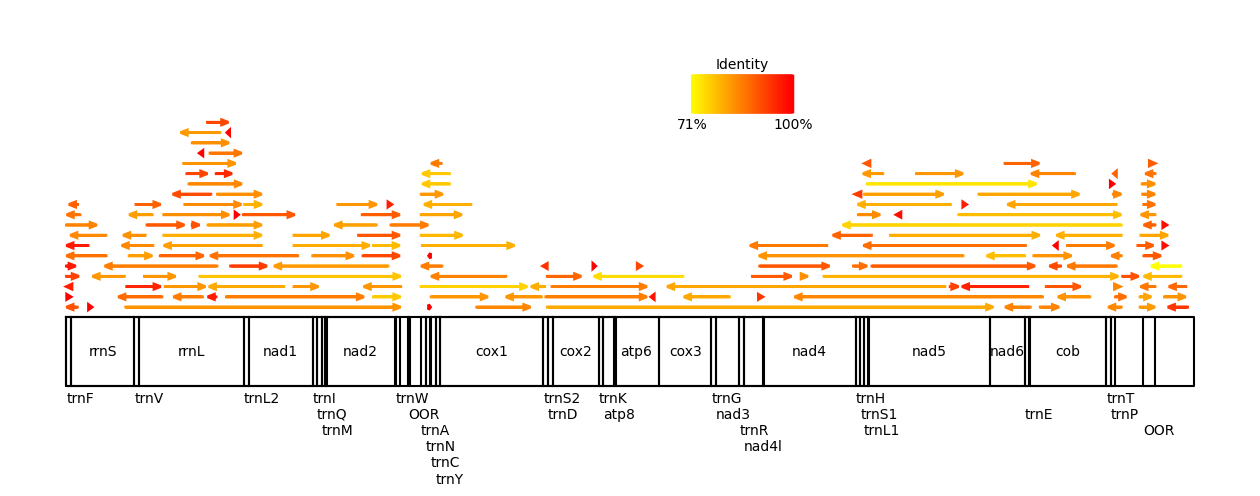

<Figure size 640x480 with 0 Axes>

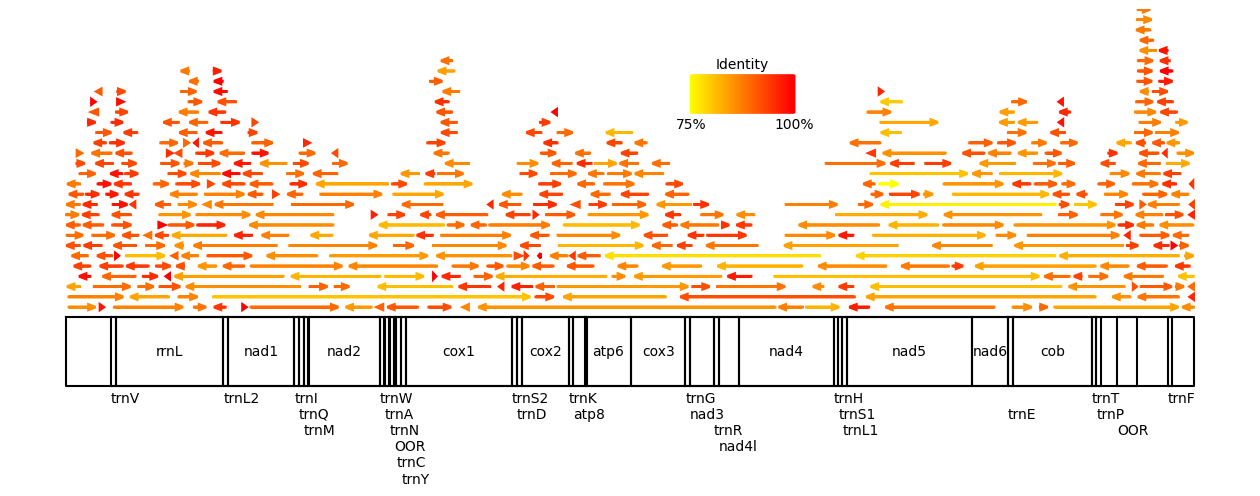

In [125]:
from matplotlib import pyplot as plt

def calculate_mtdna_start(gff_f):
    for i, line in enumerate(gff_f):
        if not line.strip() or line.startswith("#"):
            continue
        _, _, kind, start, end, _, direction, _, details, *_ = line.split()
        details = {k: v for part in details.split(";") for k, v in [part.split("=")]}
        if kind == "ncRNA_gene" and details["ID"] == "gene_trnF":
            return int(start)
    raise RuntimeError("couldn't determine mtDNA start")


def render_mtdna_with_numts(gff_f, alignments, mtdna_length):    
    fig = plt.figure(figsize=(16, 6))
    plt.axis('off')
    plt.ylim(-0.5, 4)

    TOP = 1
    BOTTOM = 0.333

    plt.plot([0, mtdna_length, mtdna_length, 0, 0], [TOP, TOP, BOTTOM, BOTTOM, TOP], color="black")

    def make_label(kind, id):
        if kind == "gene" or kind == "ncRNA_gene":
            return id.removeprefix("gene-").removeprefix("gene_")
        if kind == "D_loop":
            return "D-loop"
        if kind == "origin_of_replication":
            return "OOR"

    previous_gene_starts = []
    for i, line in enumerate(gff_f):
        if not line.strip() or line.startswith("#"):
            continue
        _, _, kind, start, end, _, direction, _, details, *_ = line.split()
        start, end = int(start), int(end)
        start = (start - mtdna_start + mtdna_length) % mtdna_length
        end = (end - mtdna_start + mtdna_length) % mtdna_length
        details = {k: v for part in details.split(";") for k, v in [part.split("=")]}
        if kind in ("D_loop", "gene", "ncRNA_gene", "origin_of_replication"):
            plt.plot([start, end, end, start, start], [TOP, TOP, BOTTOM, BOTTOM, TOP], color="black")
            if end - start < 500:
                close_genes = sum(1 for s in previous_gene_starts if start - s < 600)
                plt.text(start, BOTTOM - 0.05, "\n" * close_genes + make_label(kind, details["ID"]), verticalalignment='top')
            else:
                plt.text((start + end)/2, (TOP + BOTTOM)/2, make_label(kind, details["ID"]), horizontalalignment='center', verticalalignment='center')
            previous_gene_starts.append(start)

    min_identity = min(float(a.identity) for a in alignments)
    max_identity = max(float(a.identity) for a in alignments)
    print(f"Min identity: {min_identity}, max identity: {max_identity}")
    rows = [[] for _ in range(len(alignments))]
    OFFSET = 0.1
    BASE = 1.1
    for alignment in alignments:
        i, row = next((i, row) for i, row in enumerate(rows) if all(not alignment.intersects(a.start-50, a.end+50) for a in row))
        alpha = (float(alignment.identity) - min_identity) / (max_identity - min_identity)
        rgb = (1.0, 1.0 * (1 - alpha), 0.0)
        if alignment.direction == "+":
            arrow_start, arrow_offset = alignment.start, alignment.end - alignment.start
        else:
            arrow_start, arrow_offset = alignment.end, alignment.start - alignment.end
        arrow_start = (arrow_start - mtdna_start + mtdna_length) % mtdna_length
        plt.arrow(arrow_start, BASE + OFFSET * i, arrow_offset, 0, color=rgb, linewidth=2, length_includes_head=True, head_length=min(100, abs(arrow_offset)), head_width=0.05)
        # plt.text((alignment.start + alignment.end)/2, BASE + OFFSET * i, f"{round(float(alignment.identity))}%", horizontalalignment='center', verticalalignment='top')
        row.append(alignment)

    GRADIENT_START = int(mtdna_length * 0.6) - 1500 // 2
    GRADIENT_END = int(mtdna_length * 0.6) + 1500 // 2
    GRADIENT_TOP = 3.35
    GRADIENT_BOTTOM = 3.0

    for i in range(GRADIENT_END - GRADIENT_START + 1):
        alpha = i / (GRADIENT_END - GRADIENT_START)
        identity = max(min_identity, min(min_identity + alpha * (max_identity - min_identity), max_identity))
        rgb = (1.0, 1.0 * (1 - alpha), 0.0)
        plt.plot([GRADIENT_START + i, GRADIENT_START + i], [GRADIENT_BOTTOM, GRADIENT_TOP], color=rgb)

    plt.text((GRADIENT_START + GRADIENT_END)/2, GRADIENT_TOP + 0.05, "Identity", horizontalalignment="center", verticalalignment="bottom")
    plt.text(GRADIENT_START, GRADIENT_BOTTOM - 0.05, f"{round(min_identity)}%", horizontalalignment="center", verticalalignment="top")
    plt.text(GRADIENT_END, GRADIENT_BOTTOM - 0.05, f"{round(max_identity)}%", horizontalalignment="center", verticalalignment="top");


with open("data/ELUT_bond.gff") as f:
    lutescens_mtdna_start = calculate_mtdna_start(f)

with open("data/ETAL_bond.gff") as f:
    talpinus_mtdna_start = calculate_mtdna_start(f)

plt.figure()
with open("data/ELUT_bond.gff") as f:
    render_mtdna_with_numts(f, lutescens_alignments, lutescens_mtdna_length)
plt.figure()
with open("data/ETAL_bond.gff") as f:
    render_mtdna_with_numts(f, talpinus_alignments, talpinus_mtdna_length)

# Intersecting NUMTs with genome annotation

In [ ]:
! bedtools intersect \
    -a data/ElloLutescens_matches.bed \
    -b data/ElloLutescens_male_dna.gtf \
    -wa -wb > data/ElloLutescens_dna.intersect

! bedtools intersect \
    -a data/ElloTalpinus_matches.bed \
    -b data/ElloTalpinus_dna.gtf \
    -wa -wb > data/ElloTalpinus_dna.intersect

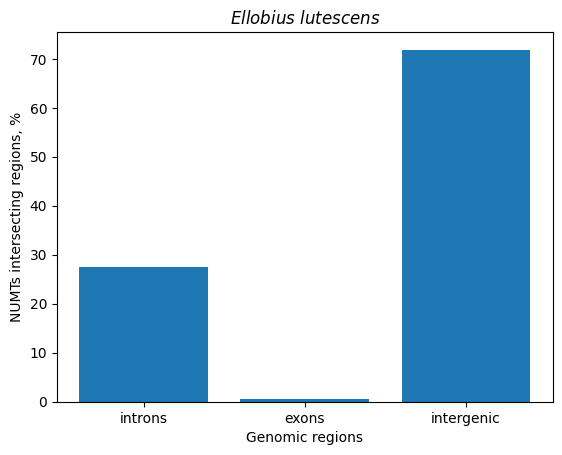

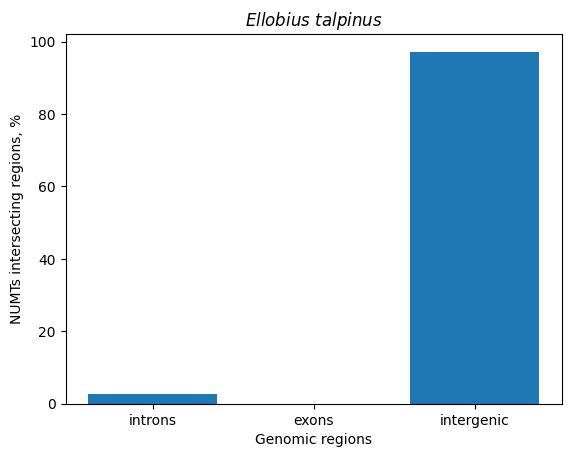

In [126]:
def plot_numts_distribution(intersect_f, alignments, species_name):
    total_numts = len(alignments)
    introns = 0
    exons = 0
    r = csv.reader(intersect_f, delimiter="\t")
    for row in r:
        kind = row[8]
        if kind == "intron":
            introns += 1
        elif kind in ("exon", "CDS"): 
            exons += 1
    intergenic = total_numts - introns - exons
    plt.bar(["introns", "exons", "intergenic"], [introns*100/total_numts, exons*100/total_numts, intergenic*100/total_numts])
    plt.xlabel("Genomic regions")
    plt.ylabel("NUMTs intersecting regions, %")
    species_name = species_name.replace(' ', '\\ ')
    plt.title(f"$\\it{{{species_name}}}$");


plt.figure()
with open("data/ElloLutescens_dna.intersect") as f:
    plot_numts_distribution(f, lutescens_alignments, "Ellobius lutescens")

plt.figure()
with open("data/ElloTalpinus_dna.intersect") as f:
    plot_numts_distribution(f, talpinus_alignments, "Ellobius talpinus")

# Intersecting NUMTs with RepeatMasker-annotated repeats

In [127]:
@dataclass
class Space:
    scaffold: str
    start: int
    end: int
    slen: int
    
    def intersects(self, start, end) -> bool:
        return start <= self.start < end or start < self.end <= end or self.start < start < end < self.end


def get_spaces_and_flanks(alignments):
    per_scaffold = defaultdict(list)
    for a in alignments:
        per_scaffold[a.scaffold].append(a)

    spaces = []
    flanks = []
    for v in per_scaffold.values():
        v.sort(key=lambda a: a.sstart)
        for n1, n2 in zip(v, v[1:]):
            if n1.end >= n2.start:
                continue
            spaces.append(Space(scaffold=n1.scaffold, start=n1.end, end=n2.start, slen=n1.slen))
        flanks.append(Space(scaffold=v[0].scaffold, start=max(0, v[0].start - 1000), end=v[0].start, slen=v[0].slen))
        flanks.append(Space(scaffold=v[0].scaffold, start=v[-1].end, end=min(v[0].slen, v[-1].end + 1000), slen=v[0].slen))
    print(f"Total NUMTs: {len(alignments)}, spaces within NUMT clusters: {len(spaces)}, flanks: {len(flanks)}")
    return spaces, flanks


lutescens_spaces, lutescens_flanks = get_spaces_and_flanks(lutescens_alignments)
talpinus_spaces, talpinus_flanks = get_spaces_and_flanks(talpinus_alignments)

Total NUMTs: 167, spaces within NUMT clusters: 31, flanks: 220
Total NUMTs: 463, spaces within NUMT clusters: 33, flanks: 678


In [128]:
from tqdm.notebook import tqdm

@dataclass(frozen=True)
class Repeat:
    scaffold: str
    sstart: int
    send: int
    divergence: float
    motif: str
    annotation: str
    intersects_space: bool
    intersects_flank: bool

def load_and_filter_repeats(repeats_f, spaces, flanks):
    repeats = []
    r = iter(csv.reader(repeats_f, delimiter="\t"))
    header = next(r)
    next(r)
    allowed_scaffolds = {a.scaffold for a in spaces + flanks}
    for row in tqdm(r):
        if row[0].startswith("#"):
            continue
        scaffold, _, _, sstart, send, divergence, _, _, info = row
        motif = info.split('"')[1].removeprefix("Motif:")
        divergence, sstart, send = float(divergence), int(sstart), int(send)
        assert sstart < send
        if scaffold in allowed_scaffolds and (
            (intersects_space := any(a.scaffold == scaffold and a.intersects(sstart, send) for a in spaces)) \
            or (intersects_flank := any(a.scaffold == scaffold and a.intersects(sstart, send) for a in flanks))):
            repeat = Repeat(
                scaffold=scaffold, sstart=sstart, send=send, divergence=divergence, 
                motif=motif, annotation="TODO",
                intersects_space=intersects_space,
                intersects_flank=intersects_flank,
            )
            repeats.append(repeat)
    return repeats


with open("data/ElloLutescens_RepeatMasker.gff") as f:
    lutescens_repeats = load_and_filter_repeats(f, lutescens_spaces, lutescens_flanks)

with open("data/ElloTalpinus_RepeatMasker.gff") as f:
    talpinus_repeats = load_and_filter_repeats(f, talpinus_spaces, talpinus_flanks)

len(lutescens_repeats), len(talpinus_repeats)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

(610, 719)

In [129]:
def remove_intersecting_repeats(repeats):
    num_intersections = 0
    remaining_repeats = set(repeats)
    for i, r1 in enumerate(repeats):
        for r2 in repeats[i+1:]:
            if r1.scaffold != r2.scaffold: continue
            if r1.sstart <= r2.sstart < r1.send or r1.sstart < r2.send <= r1.send or r2.sstart <= r1.sstart < r1.send <= r2.send:
                # print(f"{r1.motif} intersects with {r2.motif} on scaffold {r1.scaffold}")
                if r1.divergence < r2.divergence:
                    if r2 in remaining_repeats:
                        remaining_repeats.remove(r2)
                else:
                    if r1 in remaining_repeats:
                        remaining_repeats.remove(r1)
                num_intersections += 1
    print(f"Total intersections: {num_intersections}")
    print(f"Total repeats: {len(repeats)}, remaining repeats: {len(remaining_repeats)}")
    print(f"Repeats intersecting spaces: {sum(1 for r in remaining_repeats if r.intersects_space)}")
    print(f"Repeats intersecting flanks: {sum(1 for r in remaining_repeats if r.intersects_flank)}")
    return remaining_repeats

lutescens_remaining_repeats = remove_intersecting_repeats(lutescens_repeats)
talpinus_remaining_repeats = remove_intersecting_repeats(talpinus_repeats)

Total intersections: 92
Total repeats: 610, remaining repeats: 526
Repeats intersecting spaces: 181
Repeats intersecting flanks: 388
Total intersections: 122
Total repeats: 719, remaining repeats: 619
Repeats intersecting spaces: 117
Repeats intersecting flanks: 536


In [130]:
motif_to_annotation = {
    motif: annotation
    for seq in parse_fasta(open("data/representative_sequences.fasta"))
    for motif, annotation in [seq.title.split(" ")[0].split("#")]
}

In [131]:
from collections import Counter
from pprint import pprint

def count_space_and_flank_repeats(remaining_repeats):
    c1 = Counter()
    c2 = Counter()
    for repeat in sorted(remaining_repeats, key=lambda r: (r.scaffold, r.sstart)):
        if repeat.motif not in motif_to_annotation: continue
        c = c1 if repeat.intersects_space else c2
        c[motif_to_annotation.get(repeat.motif, repeat.motif)] += 1
    return c1, c2

lutescens_on_spaces, lutescens_on_flanks = count_space_and_flank_repeats(lutescens_remaining_repeats)
print("Motifs on spaces within NUMT clusters (Ellobius lutescens):")
pprint([*lutescens_on_spaces.items()], indent=4)
print("Motifs on NUMT cluster flanks (Ellobius lutescens):")
pprint([*lutescens_on_flanks.items()], indent=4)

talpinus_on_spaces, talpinus_on_flanks = count_space_and_flank_repeats(talpinus_remaining_repeats)
print("Motifs on spaces within NUMT clusters (Ellobius talpinus):")
pprint([*talpinus_on_spaces.items()], indent=4)
print("Motifs on NUMT cluster flanks (Ellobius talpinus):")
pprint([*talpinus_on_flanks.items()], indent=4)

Motifs on spaces within NUMT clusters (Ellobius lutescens):
[   ('LTR/ERVK', 25),
    ('LTR/ERVL-MaLR', 8),
    ('SINE/Alu', 42),
    ('LINE/L1', 39),
    ('SINE/B2', 20),
    ('SINE/ID', 4),
    ('Unknown', 6),
    ('DNA/TcMar-Mariner', 1),
    ('DNA/hAT-Charlie', 1),
    ('SINE/B4', 3),
    ('Simple_repeat', 3),
    ('SINE/tRNA', 1),
    ('SINE/MIR', 2),
    ('LTR/ERV1', 4)]
Motifs on NUMT cluster flanks (Ellobius lutescens):
[   ('Unknown', 12),
    ('SINE/B2', 29),
    ('SINE/Alu', 54),
    ('LTR/ERVL-MaLR', 30),
    ('LTR/ERVL', 5),
    ('LTR/ERVK', 60),
    ('LINE/L1', 66),
    ('Simple_repeat', 4),
    ('SINE/MIR', 1),
    ('DNA/TcMar-Mariner', 1),
    ('SINE/B4', 7),
    ('DNA/hAT-Charlie', 1),
    ('SINE/ID', 6),
    ('Retroposon/L1-dep', 1),
    ('DNA/TcMar-Tigger', 1),
    ('LTR/ERV1', 6),
    ('Retroposon/sno', 1)]
Motifs on spaces within NUMT clusters (Ellobius talpinus):
[   ('SINE/tRNA', 1),
    ('SINE/B4', 7),
    ('SINE/Alu', 19),
    ('LTR/ERVL-MaLR', 11),
    ('SINE/

In [132]:
keys = sorted(set(talpinus_on_spaces) | set(talpinus_on_flanks) | set(lutescens_on_spaces) | set(lutescens_on_flanks))
keys

['DNA/TcMar-Mariner',
 'DNA/TcMar-Tigger',
 'DNA/hAT-Charlie',
 'LINE/L1',
 'LINE/L2',
 'LTR',
 'LTR/ERV1',
 'LTR/ERVK',
 'LTR/ERVL',
 'LTR/ERVL-MaLR',
 'Retroposon/L1-dep',
 'Retroposon/sno',
 'SINE/Alu',
 'SINE/B2',
 'SINE/B4',
 'SINE/ID',
 'SINE/MIR',
 'SINE/U-L1',
 'SINE/tRNA',
 'Satellite',
 'Simple_repeat',
 'Unknown']

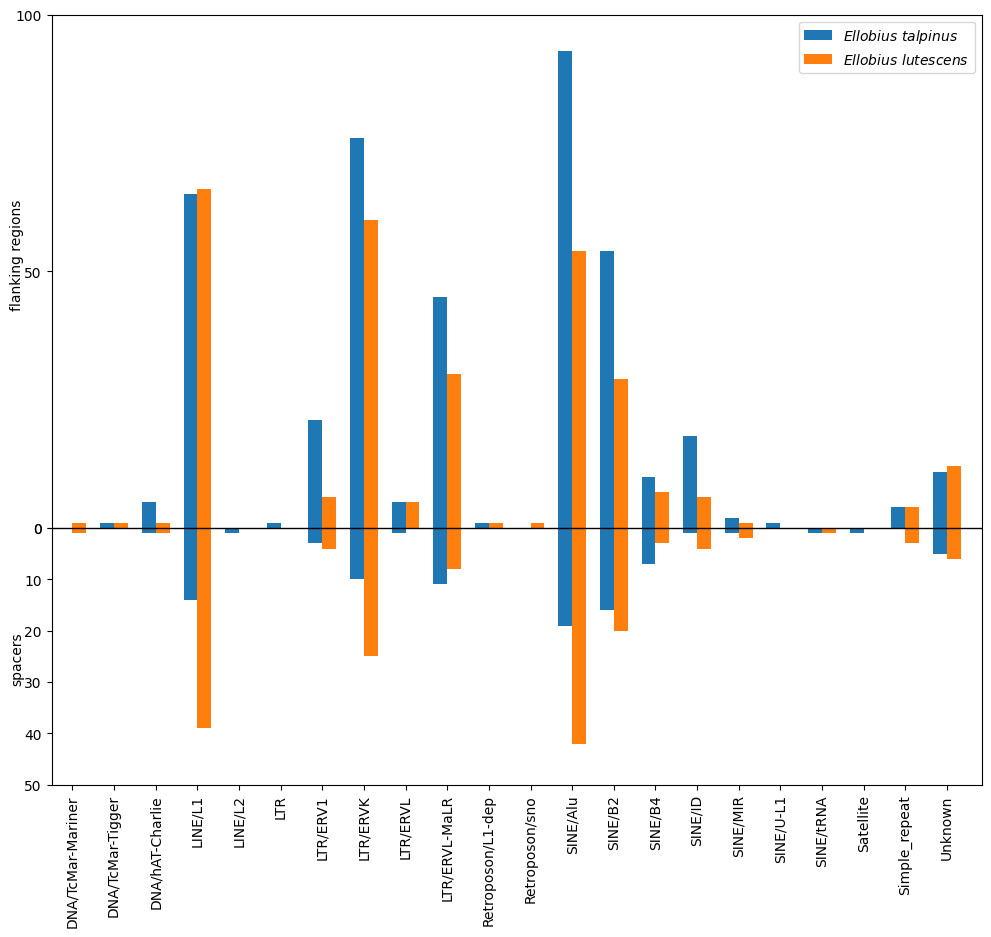

In [133]:
from matplotlib import pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
f = plt.figure(figsize=(12, 10))
ax = f.add_subplot(111)
# ax.yaxis.tick_right()
# ax.yaxis.set_label_position("right")

offset = 3

plt.bar(range(0, offset*len(keys), offset), [-talpinus_on_spaces[key] for key in keys], width=1, label=r"$Ellobius\ talpinus$", color=colors[0])
plt.bar(range(1, offset*len(keys)+1, offset), [-lutescens_on_spaces[key] for key in keys], width=1, label=r"$Ellobius\ lutescens$", color=colors[1])
plt.bar(range(0, offset*len(keys), offset), [talpinus_on_flanks[key] for key in keys], width=1, color=colors[0])
plt.bar(range(1, offset*len(keys)+1, offset), [lutescens_on_flanks[key] for key in keys], width=1, color=colors[1])

plt.plot([-1000, 1000], [0, 0], color="black", linewidth=1)
plt.text(-4, 43, "flanking regions", rotation="vertical")
plt.text(-4, -30, "spacers", rotation="vertical")
plt.yticks(list(range(-50, 1, 10)) + list(range(0, 351, 50)), [str(-x) for x in range(-50, 1, 10)] + [str(x) for x in range(0, 351, 50)])


plt.xlim(-1, offset*len(keys))
# plt.yscale("log")
# plt.ylim(-max(max(lutescens_on_spaces.values()), max(talpinus_on_spaces.values())) - 10, max(max(lutescens_on_flanks.values()), max(talpinus_on_flanks.values())) + 10)
plt.ylim(-50, 100)
plt.legend()
plt.xticks([offset*i+0.5 for i in range(len(keys))], keys, rotation="vertical");

# Analyzing clusters of NUMTs

In [134]:
from collections import Counter, defaultdict


def count_cluster_stats(alignments):
    per_scaffold = defaultdict(list)
    for a in alignments:
        per_scaffold[a.scaffold].append(a)
    
    for vs in per_scaffold.values():
        vs.sort(key=lambda a: a.sstart)

    clusters = []
    curr_cluster = []
    for vs in per_scaffold.values():
        for prev, curr in zip([None] + vs, vs):
            if prev is None or prev.send + 5000 < curr.sstart:
                if curr_cluster:
                    clusters.append(curr_cluster)
                curr_cluster = [curr]
                continue
            curr_cluster.append(curr)
    if curr_cluster:
        clusters.append(curr_cluster)
        
    clusters = [c for c in clusters if len(c) > 1]
    numts_in_clusters = sum(map(len, clusters))
    print(f"Total NUMTs: {len(alignments)}, scaffolds: {len(per_scaffold)}, clusters: {len(clusters)}, NUMTs within clusters: {numts_in_clusters}")

count_cluster_stats(lutescens_alignments)
count_cluster_stats(talpinus_alignments)

Total NUMTs: 167, scaffolds: 110, clusters: 30, NUMTs within clusters: 86
Total NUMTs: 463, scaffolds: 339, clusters: 87, NUMTs within clusters: 211


(403, 292)